# Import dependencies

In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import random

# Use GPU

In [2]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


# Declare files and directories

In [3]:
train_dir = './train'
test_dir = './test'

train_files = os.listdir(train_dir) 
test_files = os.listdir(test_dir)

print(f"Number of images in {train_dir} are {len(os.listdir(train_dir))}")
print(f"Number of images in {test_dir} are {len(os.listdir(test_dir))}")

Number of images in ./train are 4000
Number of images in ./test are 1000


# Create transformation pipeline

In [4]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

# Create dataset class

In [5]:
class Dataset(Dataset):
    def __init__(self, filelist, filepath, transform=None):
        self.filelist = filelist
        self.filepath = filepath
        self.transform = transform

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, index):
        imgpath = os.path.join(self.filepath, self.filelist[index])
        img = Image.open(imgpath)
        
        # Convert the image to RGB format to ensure consistent channel count
        img = img.convert('RGB')

        if "bike" in imgpath:
            label = 1
        else:
            label = 0 

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)


# Call the class on training and validation dataset

In [6]:
train = Dataset(train_files, train_dir, transformations)
test = Dataset(test_files, test_dir, transformations)

# Try to get the shape of a single image

In [7]:
print(test.__getitem__(1)[0].shape)
print(train.__getitem__(1)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


# Devide the training dataset into training and validation
# Keep the original test set for later

In [8]:
# Assuming train is original training dataset

train, val = torch.utils.data.random_split(train,[3000,1000]) 

In [9]:
print(f"Number of training images: {len(train)}")
print(f"Number of validation images: {len(val)}")

Number of training images: 3000
Number of validation images: 1000


# Create an array of the labels

In [10]:
val_set_class_count = [val.__getitem__(x)[1] for x in range(len(val)) ]

#val is assumed to be an instance of a dataset class, 
# similar to the CustomDataset class you defined earlier. 
#This dataset contains validation data.



#The code creates a list comprehension that iterates 
#over the range of indices corresponding to the length of the val dataset.



#For each index x, it calls val.__getitem__(x)[1] to retrieve the 
# label (class) of the sample at index x. 
# The __getitem__ method of your dataset class returns a tuple (image, label), 
# and [1] accesses the label component.


#The list comprehension constructs a list 
#containing the labels of all samples in the validation dataset.

C:\Program Files\Python39\Scripts\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Verify that the class names are balanced

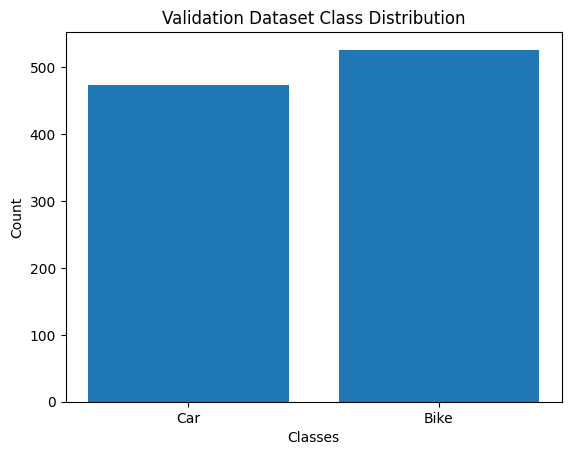

In [11]:
import matplotlib.pyplot as plt

# Calculate class counts using the val_set_class_count list
class_count = {0: 0, 1: 0}  # Initialize counts for class 0 (car) and class 1 (bike)

for label in val_set_class_count:
    class_count[label] += 1

# Create a bar plot
plt.bar(class_count.keys(), class_count.values())
plt.xticks(list(class_count.keys()), ['Car', 'Bike'])
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Validation Dataset Class Distribution')
plt.show()


# Create the dataloaders

In [12]:
train_dataset = torch.utils.data.DataLoader(dataset = train,batch_size= 32, shuffle= True)
val_dataset = torch.utils.data.DataLoader(dataset= val, batch_size= 32, shuffle= False)

# Use it to get some sample images and make sure that it makes sense

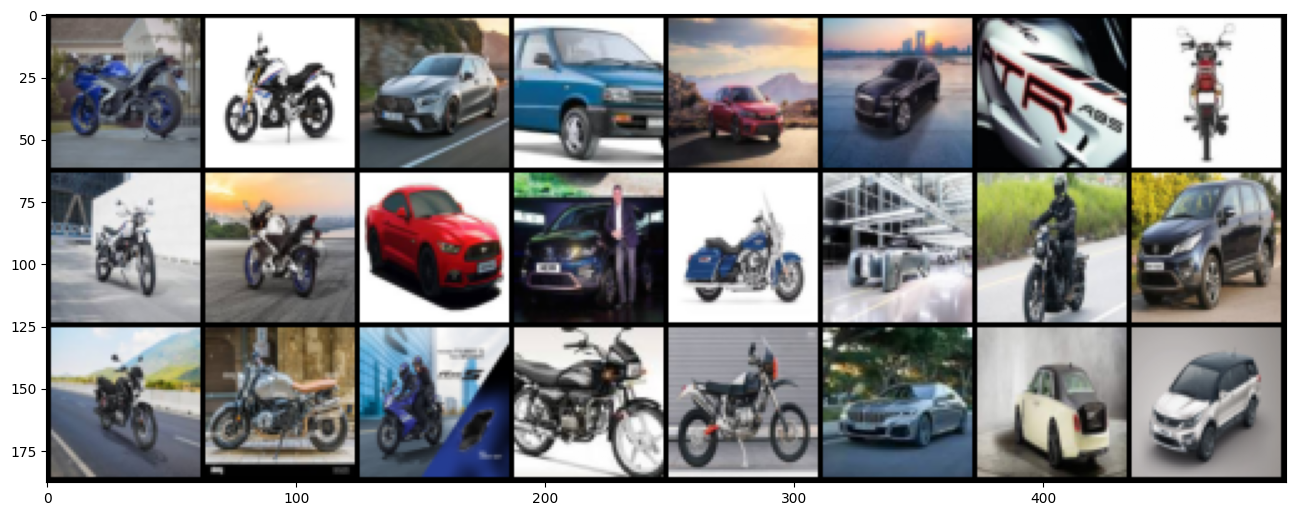

In [13]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# Create yolov3 like model using nn.Sequential

In [20]:
# Define a simplified YOLOv3-like architecture using nn.Sequential
class YOLOv3(nn.Module):
    def __init__(self, num_classes):
        super(YOLOv3, self).__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # ... add more convolutional and pooling layers ...
        )
        
        self.yolo_head = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=1),
            nn.Sigmoid()  # Assuming you're using binary classification for object detection
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.yolo_head(x)
        return x

# Create an instance of the YOLOv3-like model
num_classes = 1  # Number of classes (binary classification for object detection)
model = YOLOv3(num_classes)

# Print the model architecture
print(model)


YOLOv3(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (yolo_head): Sequential(
    (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): Sigmoid()
  )
)


# Use TorchSummary to display keras like summary

In [21]:
model = CNN()
model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

# Define loss function and optimizer

In [22]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(), lr= 0.0005)
epochs = 50

# Use tdqm to perform keras style training

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    total = 0
    correct = 0
    counter = 0
    train_running_loss = 0

    # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
    # tepoch becomes 
    with tqdm(train_dataset, unit="batch") as tepoch:
        # our progress bar labels
        tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

        for data,label in tepoch:
            data,label = data.to(device), label.to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output,label)
            loss.backward()
            optimiser.step() 

            train_running_loss += loss.item() * data.size(0)

            _, pred = torch.max(output.data, 1)

            # Keep track of how many images have been foward propagated
            total += label.size(0)
            # Keep track of how many were predicted to be correct
            correct += (pred == label).sum().item()

        train_accuracy.append(correct/total)
        train_loss.append(train_running_loss/len(train_dataset))
        print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
        print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

    # Get our validation accuracy and loss scores
    if epoch %1 == 0:
        model.eval()
        total = 0
        correct = 0
        val_running_loss = 0

        # We don't need gradients for validation, so wrap in  no_grad to save memory
        with torch.no_grad():
            for val_data, val_label in val_dataset:
                val_data, val_label = val_data.to(device), val_label.to(device)
                val_output = model(val_data)
                loss_val = criterion(val_output, val_label)

                # Calacuate the running loss by multiplying loss value by batch size
                val_running_loss += loss_val.item() * val_data.size(0)
                _, pred = torch.max(val_output.data, 1)    
                total += val_label.size(0)
                correct += (pred == val_label).sum().item()

            val_accuracy.append(correct/total)
            # Calcuate loss per epoch by dividing runing loss by number of items in validation set
            val_loss.append(val_running_loss/len(val_dataset))

            #print(val_running_loss)
            print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

C:\Users\Farzad\AppData\Local\Temp\ipykernel_21972\2802506284.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.6516666666666666
Epoch 1 Training Loss = 19.97105196181764
Epoch 1 Validation Accuracy = 0.71
Epoch 1 Validation Loss = 18.045071810483932


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.7883333333333333
Epoch 2 Training Loss = 16.434393334896008
Epoch 2 Validation Accuracy = 0.824
Epoch 2 Validation Loss = 15.422856509685516


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.8506666666666667
Epoch 3 Training Loss = 14.725863974145119
Epoch 3 Validation Accuracy = 0.859
Epoch 3 Validation Loss = 13.95974063873291


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.8856666666666667
Epoch 4 Training Loss = 13.645303038840598
Epoch 4 Validation Accuracy = 0.88
Epoch 4 Validation Loss = 13.288626983761787


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.8863333333333333
Epoch 5 Training Loss = 13.436174580391418
Epoch 5 Validation Accuracy = 0.849
Epoch 5 Validation Loss = 14.196417137980461


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.8983333333333333
Epoch 6 Training Loss = 13.037718752597241
Epoch 6 Validation Accuracy = 0.905
Epoch 6 Validation Loss = 12.789333030581474


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8996666666666666
Epoch 7 Training Loss = 13.020270464268137
Epoch 7 Validation Accuracy = 0.843
Epoch 7 Validation Loss = 14.47550693154335


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.92
Epoch 8 Training Loss = 12.450946714015718
Epoch 8 Validation Accuracy = 0.908
Epoch 8 Validation Loss = 12.551725544035435


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.922
Epoch 9 Training Loss = 12.383126740759991
Epoch 9 Validation Accuracy = 0.912
Epoch 9 Validation Loss = 12.44631139934063


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9436666666666667
Epoch 10 Training Loss = 11.820967113718073
Epoch 10 Validation Accuracy = 0.911
Epoch 10 Validation Loss = 12.415787935256958


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9403333333333334
Epoch 11 Training Loss = 11.854130511588238
Epoch 11 Validation Accuracy = 0.9
Epoch 11 Validation Loss = 12.715629041194916


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9493333333333334
Epoch 12 Training Loss = 11.64208649574442
Epoch 12 Validation Accuracy = 0.911
Epoch 12 Validation Loss = 12.344606578350067


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9596666666666667
Epoch 13 Training Loss = 11.314897296276499
Epoch 13 Validation Accuracy = 0.904
Epoch 13 Validation Loss = 12.665614411234856


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.957
Epoch 14 Training Loss = 11.303915531077283
Epoch 14 Validation Accuracy = 0.91
Epoch 14 Validation Loss = 12.54247398674488


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9616666666666667
Epoch 15 Training Loss = 11.192201715834598
Epoch 15 Validation Accuracy = 0.899
Epoch 15 Validation Loss = 12.71996684372425


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.968
Epoch 16 Training Loss = 11.043744723847572
Epoch 16 Validation Accuracy = 0.919
Epoch 16 Validation Loss = 12.313517436385155


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9783333333333334
Epoch 17 Training Loss = 10.772891983072808
Epoch 17 Validation Accuracy = 0.917
Epoch 17 Validation Loss = 12.290227591991425


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9763333333333334
Epoch 18 Training Loss = 10.785663858373114
Epoch 18 Validation Accuracy = 0.916
Epoch 18 Validation Loss = 12.318608783185482


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9743333333333334
Epoch 19 Training Loss = 10.851436135616709
Epoch 19 Validation Accuracy = 0.912
Epoch 19 Validation Loss = 12.379379995167255


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9626666666666667
Epoch 20 Training Loss = 11.134918557836654
Epoch 20 Validation Accuracy = 0.926
Epoch 20 Validation Loss = 12.184096731245518


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9716666666666667
Epoch 21 Training Loss = 10.924035145881328
Epoch 21 Validation Accuracy = 0.903
Epoch 21 Validation Loss = 12.689060620963573


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.981
Epoch 22 Training Loss = 10.632557280520176
Epoch 22 Validation Accuracy = 0.92
Epoch 22 Validation Loss = 12.231450639665127


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9806666666666667
Epoch 23 Training Loss = 10.619903988026557
Epoch 23 Validation Accuracy = 0.922
Epoch 23 Validation Loss = 12.263609528541565


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.985
Epoch 24 Training Loss = 10.489267356852269
Epoch 24 Validation Accuracy = 0.922
Epoch 24 Validation Loss = 12.076543644070625


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.987
Epoch 25 Training Loss = 10.437562777640972
Epoch 25 Validation Accuracy = 0.919
Epoch 25 Validation Loss = 12.245486557483673


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9863333333333333
Epoch 26 Training Loss = 10.463539993509333
Epoch 26 Validation Accuracy = 0.911
Epoch 26 Validation Loss = 12.320575661957264


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.987
Epoch 27 Training Loss = 10.431482497681962
Epoch 27 Validation Accuracy = 0.917
Epoch 27 Validation Loss = 12.280260868370533


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9763333333333334
Epoch 28 Training Loss = 10.755888642148768
Epoch 28 Validation Accuracy = 0.91
Epoch 28 Validation Loss = 12.427399978041649


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.981
Epoch 29 Training Loss = 10.625640402448939
Epoch 29 Validation Accuracy = 0.922
Epoch 29 Validation Loss = 12.213798992335796


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9813333333333333
Epoch 30 Training Loss = 10.570811619149877
Epoch 30 Validation Accuracy = 0.912
Epoch 30 Validation Loss = 12.458239153027534


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.9876666666666667
Epoch 31 Training Loss = 10.410276169472553
Epoch 31 Validation Accuracy = 0.89
Epoch 31 Validation Loss = 13.116648644208908


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9826666666666667
Epoch 32 Training Loss = 10.55535656086942
Epoch 32 Validation Accuracy = 0.898
Epoch 32 Validation Loss = 12.772413857281208


  0%|          | 0/94 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9816666666666667
Epoch 33 Training Loss = 10.592610752328913
Epoch 33 Validation Accuracy = 0.915
Epoch 33 Validation Loss = 12.410253301262856


  0%|          | 0/94 [00:00<?, ?batch/s]

# Performance Plot

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Save model

In [ ]:
model_filename = 'car_vs_bike_yolov3.pth'
torch.save(model.state_dict(), model_filename)

print(f"Model saved to {model_filename}")


# Visualize Prediction

In [ ]:
samples, _ = iter(val_dataset).next()
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'Bike', 1:'Car'}

for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))